
##### A. Describe how you generated your data for the Cosine reconstruction task. How many data points did you generate? Was this sufficient to cover the possible signals the network would need to see? How did you generate a test set? Did you use the same distribution as the training data, or did you focus on a particular range of amplitudes? 

I generated the data by using numpy cos function and random function to generate different shifts and amplitude cosine waves. 
I generated 100 points between 0 and 10 time steps for each of the 15000 cosine waves with amplitude (0.5, 1.5) .<br />
The test set was made by generating 1000 random cosine waves. For the test set, I generated 1000 cosine waves randomly with amplitude (0.5, 1.5) to check how the network performs.


##### B. For your network, what did you use for your:<br />

__1. RNN Hidden Size__<br />
I used 400 hidden layers. <br /><br />
__2. Nonlinearity__<br />
Tanh <br /><br />
__3. Other Network Layers (FC, dropout, etc.)__<br />
Used FC for output without activation. <br /> <br />
__4. Training Epochs__<br />
15000 <br /><br />
__5. Learning Rate__<br />
0.00001 <br /><br />

##### C. Please plot at least one example each of signals in your test which were accurately and inaccurately reconstructed. You can use the MSE loss to determine the best (low-error) and worst (high-error) samples. From those, plot the true signal (the input) and the signal your network predicted. In the comments, please describe what you notice about what your network is good at capturing and what it struggles with. Try explaining why this might be.

Plotted the required examples using MSE loss. I notice that the network is good at copturing the general shape of the signal. However, accrautely capturing priodicity and amplitude of the wave is difficult.





In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Cosine: Random shifts and amplitudes')

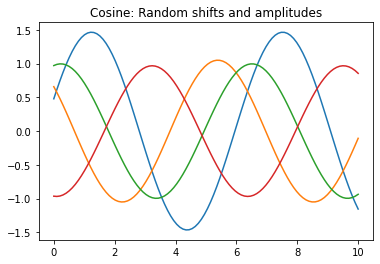

In [2]:
f = plt.figure()
for i in range(4):
  x = np.linspace(0,10,100)+2*np.pi*np.random.rand()
  amp = np.random.rand()+0.5
  y = amp*np.cos(x)
  plt.plot(np.linspace(0,10,100), y)
plt.title('Cosine: Random shifts and amplitudes')

In [3]:
# Model Definition
class CosineRNN(nn.Module):
  def __init__(self, p = 0.5, hidden_size = 128):
    super(CosineRNN, self).__init__()
    self.rnn_layer = nn.RNN(input_size = 1, hidden_size = hidden_size)
    self.out_layer = nn.Linear(in_features = hidden_size, out_features = 1)
    self.p = p #Whether to use actual seq or output for next step
    
  def forward(self,seq, h = None):
        out = []
        X_in = torch.unsqueeze(seq[0],0)
        for X in seq:
            if np.random.rand()>self.p: #Use teacher forcing
                X_in = X.unsqueeze(dim = 0)
            tmp, h = self.rnn_layer(X_in, h)
            X_in = self.out_layer(tmp)
            out.append(X_in)
        return torch.stack(out).squeeze(1), h

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seq = CosineRNN(hidden_size=400).to(device)
criterion = nn.MSELoss()
train_data = []
optimizer = optim.Adam(seq.parameters(), lr=0.00001)
max_iters = 15000
train_loss = []
for i in range(max_iters):
    amp = np.random.rand()+0.5
    data = amp * np.cos(np.linspace(0,10,100)+2*np.pi*np.random.rand())
    xs = data[:-1]
    ys = data[1:]
    X = torch.Tensor(xs).view(-1,1,1).to(device)
    y = torch.Tensor(ys).to(device)
    if i%100==0:
        seq.p = min(seq.p+0.1,0.85)  # encourage training longer term predictions
    optimizer.zero_grad()
    rnn_out,_ = seq(X)
    loss = criterion(rnn_out[20:].view(-1),y[20:])
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if i%500 == 0:
        print(f"i {i}, loss {loss.data:.4f}")

i 0, loss 0.1365
i 500, loss 0.7787
i 1000, loss 0.0427
i 1500, loss 0.0514
i 2000, loss 0.0217
i 2500, loss 0.0241
i 3000, loss 0.0023
i 3500, loss 0.0151
i 4000, loss 0.0120
i 4500, loss 0.0055
i 5000, loss 0.0246
i 5500, loss 0.0325
i 6000, loss 0.0210
i 6500, loss 0.1153
i 7000, loss 0.0169
i 7500, loss 0.0370
i 8000, loss 0.0358
i 8500, loss 0.0245
i 9000, loss 0.0057
i 9500, loss 0.0135
i 10000, loss 0.0008
i 10500, loss 0.0103
i 11000, loss 0.0069
i 11500, loss 0.0060
i 12000, loss 0.0048
i 12500, loss 0.0447
i 13000, loss 0.0030
i 13500, loss 0.0094
i 14000, loss 0.0036
i 14500, loss 0.0185


In [5]:
from matplotlib import pyplot as plt
min_value = float("inf")
val_data_min = -1
val_data_max = 1
max_value = float("-inf")
val_data = []
for _ in range(1000):
    amp = np.random.rand()+0.5
    y = amp * np.cos(np.linspace(0,100,1000)+2*np.pi*np.random.rand())
    X = torch.Tensor(y)[:100].view(-1,1,1).to(device)
    model_out,h = seq(X)
    preds = []
    pred = model_out[-1].view(1,1,1)
    for i in range(1000):
        pred,h = seq(pred,h)
        preds.append(pred.cpu().data.numpy().ravel()[0])

    # plt.figure(figsize=[10,8])
    xst = xs = np.arange(model_out.size(0))
    
    ys = model_out.cpu().data.numpy().ravel()
    # plt.plot(xs, ys)
    xs = np.arange(1000)+len(xs)
    # plt.plot(xs,preds)
    # plt.plot(y)
    # plt.legend(['seeding','RNN','real'])
    # plt.title('Sine wave')
    
    val_loss = criterion(torch.Tensor(preds[:-100]), torch.Tensor(y[100:]))
    if min_value > val_loss:
        min_value = val_loss
        val_data_min = ((xst, ys, xs, preds, y, val_loss))
    if max_value < val_loss:
        max_value = val_loss
        val_data_max = ((xst, ys, xs, preds, y, val_loss))
        
    print(f'Validation Loss: {val_loss}')

Validation Loss: 0.31792542338371277
Validation Loss: 0.15409958362579346
Validation Loss: 0.19448168575763702
Validation Loss: 0.17150408029556274
Validation Loss: 0.2212238758802414
Validation Loss: 0.23300482332706451
Validation Loss: 0.16150052845478058
Validation Loss: 0.16974318027496338
Validation Loss: 0.15251784026622772
Validation Loss: 0.16761618852615356
Validation Loss: 0.15121498703956604
Validation Loss: 0.1885240077972412
Validation Loss: 0.15770789980888367
Validation Loss: 0.16146747767925262
Validation Loss: 0.16052283346652985
Validation Loss: 0.14467957615852356
Validation Loss: 0.17656826972961426
Validation Loss: 0.2329256385564804
Validation Loss: 0.22600343823432922
Validation Loss: 0.2843717038631439
Validation Loss: 0.21361827850341797
Validation Loss: 0.2087196558713913
Validation Loss: 0.2818983197212219
Validation Loss: 0.2285403162240982
Validation Loss: 0.14794886112213135
Validation Loss: 0.2596282362937927
Validation Loss: 0.24662400782108307
Validatio

In [6]:
val_data_min[-1], val_data_max[-1]

(tensor(0.1049), tensor(0.3472))

Text(0.5, 1.0, 'Cosine wave')

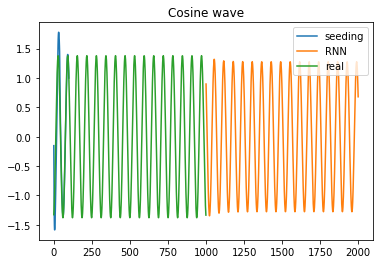

In [7]:
# Min Plot
xst, ys, xs, preds, y, _ = val_data_min
plt.plot(xst, ys)
xs = np.arange(1000)+len(xs)
plt.plot(xs,preds)
plt.plot(y)
plt.legend(['seeding','RNN','real'])
plt.title('Cosine wave')


Text(0.5, 1.0, 'Cosine wave')

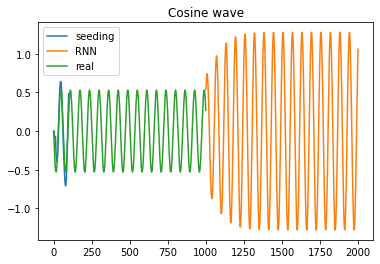

In [8]:
# Max Plot
xst, ys, xs, preds, y, _ = val_data_max
plt.plot(xst, ys)
xs = np.arange(1000)+len(xs)
plt.plot(xs,preds)
plt.plot(y)
plt.legend(['seeding','RNN','real'])
plt.title('Cosine wave')
